Installation

In [99]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [100]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [101]:
pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Required Libraries


In [102]:

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize


from pandas.core.common import random_state
from sklearn.metrics import accuracy_score

import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt



Read csv files 

In [103]:
file_1 = pd.read_csv('3d_distances.csv')
file_2 = pd.read_csv('angles.csv')
file_3 = pd.read_csv('labels.csv')
file_4 = pd.read_csv('landmarks.csv')
file_5 = pd.read_csv('xyz_distances.csv')

In [104]:
merged_data = pd.merge(file_4,file_5,on='pose_id')
merged_data = pd.merge(merged_data,file_1,on='pose_id')
merged_data = pd.merge(merged_data,file_2,on='pose_id')

merged_data = pd.merge(merged_data,file_3,on='pose_id')

In [105]:
merged_data.shape

(1372, 172)

In [106]:
merged_data = merged_data.drop('pose_id',axis=1)
merged_data = merged_data.drop('right_knee_mid_hip_left_knee',axis=1)

In [107]:
merged_data.shape

(1372, 170)

In [108]:
merged_data['pose']

0       jumping_jacks_down
1       jumping_jacks_down
2       jumping_jacks_down
3       jumping_jacks_down
4       jumping_jacks_down
               ...        
1367             squats_up
1368             squats_up
1369             squats_up
1370             squats_up
1371             squats_up
Name: pose, Length: 1372, dtype: object

In [109]:
merged_data.iloc[:0,:]

,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,x_left_eye_outer,...,left_ankle_right_ankle,left_hip_avg_left_wrist_left_ankle,right_hip_avg_right_wrist_right_ankle,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder,pose


In [110]:
merged_data.head()

,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,x_left_eye_outer,...,left_ankle_right_ankle,left_hip_avg_left_wrist_left_ankle,right_hip_avg_right_wrist_right_ankle,right_elbow_right_shoulder_right_hip,left_elbow_left_shoulder_left_hip,right_hip_right_knee_right_ankle,left_hip_left_knee_left_ankle,right_wrist_right_elbow_right_shoulder,left_wrist_left_elbow_left_shoulder,pose
0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,-2.032406,...,8.817467,24.935423,21.897507,14.021934,8.209491,129.223340,116.203650,138.059770,141.57338,jumping_jacks_down
1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,-1.494903,...,10.478581,70.999214,66.304980,67.077340,75.857120,33.741722,33.625260,149.027540,155.01839,jumping_jacks_down
2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,-0.019743,...,9.337358,75.719420,73.916530,74.106384,75.378140,29.761814,29.707142,150.370900,150.90870,jumping_jacks_down
3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,-1.753780,...,9.881827,60.924847,59.798840,60.998230,68.259796,51.646942,49.793900,139.172230,146.24620,jumping_jacks_down
4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,0.969290,...,5.223047,23.287280,19.660568,28.631880,20.923730,133.069700,134.827160,122.640205,105.69104,jumping_jacks_down


In [111]:
merged_data['pose'].unique()

array(['jumping_jacks_down', 'jumping_jacks_up', 'pullups_down',
       'pullups_up', 'pushups_down', 'pushups_up', 'situp_down',
       'situp_up', 'squats_down', 'squats_up'], dtype=object)

In [112]:
copy = merged_data

In [113]:
merged_data['pose'].value_counts()

pose
jumping_jacks_down    189
jumping_jacks_up      181
pullups_down          154
pushups_up            144
squats_up             139
pullups_up            135
squats_down           127
pushups_down          102
situp_down            102
situp_up               99
Name: count, dtype: int64

separate features,target_variable

In [114]:
from sklearn.model_selection import train_test_split
x= merged_data.drop(['pose'], axis='columns')
y = merged_data['pose']

In [115]:
encoder = LabelEncoder()
y = merged_data['pose']
y = encoder.fit_transform(y)

In [116]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {}
for idx, k in enumerate(class_weights):
    class_weights_dict[idx] = k

In [117]:
class_weights_dict

{0: 0.725925925925926,
 1: 0.7580110497237569,
 2: 0.8909090909090909,
 3: 1.0162962962962963,
 4: 1.3450980392156864,
 5: 0.9527777777777777,
 6: 1.3450980392156864,
 7: 1.385858585858586,
 8: 1.0803149606299212,
 9: 0.9870503597122302}

In [118]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# x = x.drop(['pose_id'],axis=1)
x = scaler.fit_transform(x)
x

array([[0.45927021, 0.07086989, 0.58230487, ..., 0.61825183, 0.77380677,
        0.75984575],
       [0.4717603 , 0.03599226, 0.46042203, ..., 0.12289535, 0.83780464,
        0.84864541],
       [0.48228273, 0.04406219, 0.44800554, ..., 0.09939204, 0.84564326,
        0.82150232],
       ...,
       [0.46418346, 0.11346048, 0.70909066, ..., 0.87221893, 0.76615948,
        0.6115857 ],
       [0.43201942, 0.11854186, 0.71773288, ..., 0.97123439, 0.85507982,
        0.85096232],
       [0.44587077, 0.10950291, 0.71433691, ..., 0.99005956, 0.77879057,
        0.71300375]])

In [119]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [120]:
X_train.shape

(1097, 169)

In [121]:
X_test.shape

(275, 169)

In [122]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)

classifier.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [123]:
y_pred = classifier.predict(X_test)
accuracy_rf = accuracy_score(Y_test,y_pred)

In [124]:
print(accuracy_rf)

0.8363636363636363


In [125]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.95      0.92      0.94        39
           2       0.86      0.80      0.83        30
           3       0.81      0.79      0.80        33
           4       0.93      0.93      0.93        15
           5       0.93      0.97      0.95        29
           6       0.72      0.78      0.75        23
           7       0.62      0.65      0.63        20
           8       0.89      0.92      0.91        26
           9       0.74      0.69      0.71        29

    accuracy                           0.84       275
   macro avg       0.83      0.83      0.83       275
weighted avg       0.84      0.84      0.84       275



In [126]:
from sklearn import svm
classifier_2 = svm.SVC()
classifier_2.fit(X_train,Y_train)

SVC()

In [127]:
y_pred = classifier_2.predict(X_test)
accuracy_svm = accuracy_score(Y_test,y_pred)
print(accuracy_svm)

0.7745454545454545


In [128]:
from sklearn.tree import DecisionTreeClassifier
classifier_3 = DecisionTreeClassifier(random_state = 0)
classifier_3.fit(X_train,Y_train)


DecisionTreeClassifier(random_state=0)

In [129]:
y_pred = classifier_3.predict(X_test)
accuracy = accuracy_score(Y_test,y_pred)
print(accuracy)


0.7745454545454545


In [130]:
print(classification_report(Y_test,y_pred))


              precision    recall  f1-score   support

           0       0.71      0.81      0.76        31
           1       0.87      0.85      0.86        39
           2       0.70      0.63      0.67        30
           3       0.83      0.73      0.77        33
           4       0.67      0.93      0.78        15
           5       0.88      0.97      0.92        29
           6       0.94      0.70      0.80        23
           7       0.74      0.70      0.72        20
           8       0.81      0.85      0.83        26
           9       0.60      0.62      0.61        29

    accuracy                           0.77       275
   macro avg       0.77      0.78      0.77       275
weighted avg       0.78      0.77      0.77       275



In [131]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

#Input : Image

In [132]:
# import cv2
# sample_img  = cv2.imread(r"TestImages/pullups.jpeg") #uploaded this image to colab
# plt.figure(figsize = [10,10])                 #compress the size of image to 10x10
# plt.title("sample_Image");
# plt.axis('off');                    #removes the labels
# plt.imshow(sample_img[:,:,::-1]);  #converted bgr to rgb becoz to plt.show() expects rgb
# plt.show()                          #prints the image

#Input : Video 

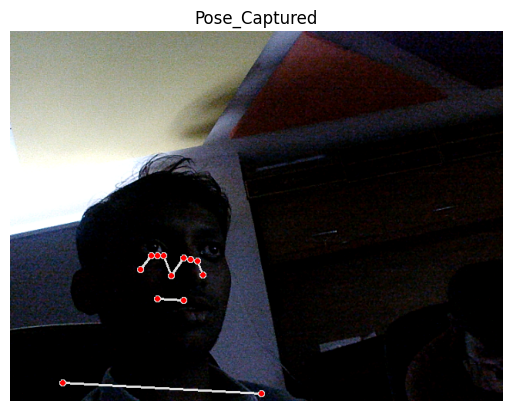

In [133]:
import cv2
import mediapipe as mp
import numpy as np
import time

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

points = mp_pose.PoseLandmark       

data = []

for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) 


def capture_image_and_landmarks():
    cap = cv2.VideoCapture(0)

    start_time = time.time()
    last_frame = None

    while time.time() - start_time <= 10:
        ret, frame = cap.read()

        if not ret:
            print("Failed to capture frame.")
            break

        imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = pose.process(imgRGB)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            landmarks = results.pose_landmarks.landmark

            dict = {}
            for point, landmark in zip(points, landmarks):
                dict[point.name] = [landmark.x, landmark.y, landmark.z]

        last_frame = frame  

        cv2.imshow("Camera", frame)
        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()

    return last_frame


last_frame = capture_image_and_landmarks()


if last_frame is not None:
    plt.title("Pose_Captured")
    plt.axis('off')                     
    plt.imshow(last_frame[:,:,::-1])     
    plt.show()                          
else:
    print("No frames captured.")

sample_img = last_frame


In [134]:
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [135]:
image_height, image_width, _ = sample_img.shape

if results.pose_landmarks:

    for i in range(11,20):

        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

LEFT_SHOULDER:
x: 326.4813995361328
y: 470.24548530578613
z: -144.19158935546875
visibility: 0.9862379431724548

RIGHT_SHOULDER:
x: 72.30513572692871
y: 456.3518714904785
z: -179.49710845947266
visibility: 0.9779453873634338

LEFT_ELBOW:
x: 399.71797943115234
y: 643.9541244506836
z: -131.5917205810547
visibility: 0.13585282862186432

RIGHT_ELBOW:
x: -0.04368399269878864
y: 642.4570083618164
z: -157.2511863708496
visibility: 0.3146609663963318

LEFT_WRIST:
x: 402.90294647216797
y: 751.3623046875
z: -386.31492614746094
visibility: 0.050307754427194595

RIGHT_WRIST:
x: 47.980618476867676
y: 764.1864395141602
z: -387.4165725708008
visibility: 0.04011571407318115

LEFT_PINKY:
x: 415.15933990478516
y: 788.5281944274902
z: -451.3636779785156
visibility: 0.06020750850439072

RIGHT_PINKY:
x: 55.85207939147949
y: 815.6545829772949
z: -455.65441131591797
visibility: 0.04759284481406212

LEFT_INDEX:
x: 401.2132263183594
y: 781.1451530456543
z: -484.603271484375
visibility: 0.08921981602907181



In [136]:
img_copy = sample_img.copy()
height, width, _ = img_copy.shape
landmarks = []

if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    for landmark in results.pose_landmarks.landmark:

            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
   
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display.
    # plt.title("Output");
    # plt.axis('off');
    # plt.imshow(img_copy[:,:,::-1]);
    # plt.show()

<Figure size 1000x1000 with 0 Axes>

In [137]:
points = mp_pose.PoseLandmark      
     
data = []
for p in points:
  print(p)
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


#When Running in google-colab -> uncomment code with %

In [138]:
# from google.colab.patches import cv2_imshow   #-------GoogleColab Instruction line----------


In [139]:
count = 0
temp = []
img = sample_img

        

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
       

blackie = np.zeros(img.shape) 

results = pose.process(imgRGB)

if results.pose_landmarks:
        mp_drawing.draw_landmarks(blackie, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) # draw landmarks on blackie

        landmarks = results.pose_landmarks.landmark

        dict = {}
        for point, j in zip(points, landmarks):
                temp = temp + [j.x, j.y, j.z]
  
                key = point.name
                value = [temp[count], temp[count+1], temp[count+2]]
                dict[key] = value
                count = count + 1

# cv2.imshow('img',img)

# cv2.imshow('blackie',blackie)

# cv2_imshow(img)               #-------GoogleColab Instruction line----------
# cv2_imshow(blackie)           #-------GoogleColab Instruction line----------


Some additional distances that are not calculated by media_pose but are present in training dataset

In [140]:
#xyz_distances
x_left_shoulder_left_wrist = dict['LEFT_WRIST'][0] - dict['LEFT_SHOULDER'][0] #(0.48930972814559937)-(-0.276510596275329)
y_left_shoulder_left_wrist = dict['LEFT_WRIST'][1] - dict['LEFT_SHOULDER'][1]#(0.143650084733963) -  (0.4948402941226959)
z_left_shoulder_left_wrist =  dict['LEFT_WRIST'][2] - dict['LEFT_SHOULDER'][2]#(-0.3052274286746979) - (0.14425188302993774)

x_right_shoulder_right_wrist = dict['RIGHT_WRIST'][0] - dict['RIGHT_SHOULDER'][0]#0.143650084733963 - 0.4948402941226959
y_right_shoulder_right_wrist = dict['RIGHT_WRIST'][1] - dict['RIGHT_SHOULDER'][1]#(-0.3052274286746979) -	0.14425188302993774
z_right_shoulder_right_wrist = dict['RIGHT_WRIST'][2] - dict['RIGHT_SHOULDER'][2]#0.48236632347106934 - (-0.3048369586467743)

x_left_hip_left_ankle	= dict['LEFT_ANKLE'][0] - dict['LEFT_HIP'][0]#0.5012699365615845 - (-0.12573319673538208)
y_left_hip_left_ankle	= dict['LEFT_ANKLE'][1] - dict['LEFT_HIP'][1]#0.1965891420841217 - 0.45757120847702026
z_left_hip_left_ankle	= dict['LEFT_ANKLE'][2] - dict['LEFT_HIP'][2]#(-0.24418438971042633)- 0.15223582088947296

x_right_hip_right_ankle	=  dict['RIGHT_ANKLE'][0] - dict['RIGHT_HIP'][0]
y_right_hip_right_ankle	= dict['RIGHT_ANKLE'][1] - dict['RIGHT_HIP'][1]
z_right_hip_right_ankle = dict['RIGHT_ANKLE'][2] - dict['RIGHT_HIP'][2]

x_left_hip_left_wrist	= dict['LEFT_WRIST'][0] - dict['LEFT_HIP'][0]
y_left_hip_left_wrist	=  dict['LEFT_WRIST'][1] - dict['LEFT_HIP'][1]
z_left_hip_left_wrist	=  dict['LEFT_WRIST'][2] - dict['LEFT_HIP'][2]

x_right_hip_right_wrist	= dict['RIGHT_WRIST'][0] - dict['RIGHT_HIP'][0]
y_right_hip_right_wrist	= dict['RIGHT_WRIST'][1] - dict['RIGHT_HIP'][1]
z_right_hip_right_wrist	= dict['RIGHT_WRIST'][2] - dict['RIGHT_HIP'][2]

x_left_shoulder_left_ankle	= dict['LEFT_ANKLE'][0] - dict['LEFT_SHOULDER'][0]
y_left_shoulder_left_ankle = dict['LEFT_ANKLE'][1] - dict['LEFT_SHOULDER'][1]
z_left_shoulder_left_ankle = dict['LEFT_ANKLE'][2] - dict['LEFT_SHOULDER'][2]

x_right_shoulder_right_ankle = dict['RIGHT_ANKLE'][0] - dict['RIGHT_SHOULDER'][0]
y_right_shoulder_right_ankle = dict['RIGHT_ANKLE'][1] - dict['RIGHT_SHOULDER'][1]
z_right_shoulder_right_ankle = dict['RIGHT_ANKLE'][2] - dict['RIGHT_SHOULDER'][2]

x_left_hip_right_wrist = dict['RIGHT_WRIST'][0] - dict['LEFT_HIP'][0]
y_left_hip_right_wrist = dict['RIGHT_WRIST'][1] - dict['LEFT_HIP'][1]
z_left_hip_right_wrist = dict['RIGHT_WRIST'][2] - dict['LEFT_HIP'][2]

x_right_hip_left_wrist = dict['LEFT_WRIST'][0] - dict['RIGHT_HIP'][0]
y_right_hip_left_wrist	= dict['LEFT_WRIST'][1] - dict['RIGHT_HIP'][1]
z_right_hip_left_wrist	= dict['LEFT_WRIST'][2] - dict['RIGHT_HIP'][2]

x_left_elbow_right_elbow = dict['RIGHT_ELBOW'][0] - dict['LEFT_ELBOW'][0]
y_left_elbow_right_elbow = dict['RIGHT_ELBOW'][1] - dict['LEFT_ELBOW'][1]
z_left_elbow_right_elbow = dict['RIGHT_ELBOW'][2] - dict['LEFT_ELBOW'][2]

x_left_knee_right_knee = dict['RIGHT_KNEE'][0] - dict['LEFT_KNEE'][0]
y_left_knee_right_knee	= dict['RIGHT_KNEE'][1] - dict['LEFT_KNEE'][1]
z_left_knee_right_knee	= dict['RIGHT_KNEE'][2] - dict['LEFT_KNEE'][2]

x_left_wrist_right_wrist = dict['RIGHT_WRIST'][0] - dict['LEFT_WRIST'][0]
y_left_wrist_right_wrisT = dict['RIGHT_WRIST'][1] - dict['LEFT_WRIST'][1]
z_left_wrist_right_wrist = dict['RIGHT_WRIST'][2] - dict['LEFT_WRIST'][2]

x_left_ankle_right_ankle = dict['RIGHT_ANKLE'][0] - dict['LEFT_ANKLE'][0]
y_left_ankle_right_ankle	= dict['RIGHT_ANKLE'][1] - dict['LEFT_ANKLE'][1]
z_left_ankle_right_ankle = dict['RIGHT_ANKLE'][2] - dict['LEFT_ANKLE'][2]

x_left_hip_avg_left_wrist_left_ankle = dict['LEFT_HIP'][0]-(dict['LEFT_WRIST'][0] + dict['LEFT_ANKLE'][0])/2
y_left_hip_avg_left_wrist_left_ankle = dict['LEFT_HIP'][1]-(dict['LEFT_WRIST'][1] + dict['LEFT_ANKLE'][1])/2
z_left_hip_avg_left_wrist_left_ankle = dict['LEFT_HIP'][2]-(dict['LEFT_WRIST'][2] + dict['LEFT_ANKLE'][2])/2

x_right_hip_avg_right_wrist_right_ankle = dict['RIGHT_HIP'][0]-(dict['RIGHT_WRIST'][0] + dict['RIGHT_ANKLE'][0])/2
y_right_hip_avg_right_wrist_right_ankle	= dict['RIGHT_HIP'][1]-(dict['RIGHT_WRIST'][1] + dict['RIGHT_ANKLE'][1])/2
z_right_hip_avg_right_wrist_right_ankle = dict['RIGHT_HIP'][2]-(dict['RIGHT_WRIST'][2] + dict['RIGHT_ANKLE'][2])/2


In [141]:
#xyz_distances
c1 = dict['LEFT_WRIST'][0] - dict['LEFT_SHOULDER'][0]
c2 = dict['LEFT_WRIST'][1] - dict['LEFT_SHOULDER'][1]
c3 =  dict['LEFT_WRIST'][2] - dict['LEFT_SHOULDER'][2]

c4 = dict['RIGHT_WRIST'][0] - dict['RIGHT_SHOULDER'][0]
c5 = dict['RIGHT_WRIST'][1] - dict['RIGHT_SHOULDER'][1]
c6 = dict['RIGHT_WRIST'][2] - dict['RIGHT_SHOULDER'][2]

c7	= dict['LEFT_ANKLE'][0] - dict['LEFT_HIP'][0]
c8	= dict['LEFT_ANKLE'][1] - dict['LEFT_HIP'][1]
c9	= dict['LEFT_ANKLE'][2] - dict['LEFT_HIP'][2]

c10	=  dict['RIGHT_ANKLE'][0] - dict['RIGHT_HIP'][0]
c11	= dict['RIGHT_ANKLE'][1] - dict['RIGHT_HIP'][1]
c12 = dict['RIGHT_ANKLE'][2] - dict['RIGHT_HIP'][2]

c13	= dict['LEFT_WRIST'][0] - dict['LEFT_HIP'][0]
c14	=  dict['LEFT_WRIST'][1] - dict['LEFT_HIP'][1]
c15=  dict['LEFT_WRIST'][2] - dict['LEFT_HIP'][2]

c16	= dict['RIGHT_WRIST'][0] - dict['RIGHT_HIP'][0]
c17	= dict['RIGHT_WRIST'][1] - dict['RIGHT_HIP'][1]
c18= dict['RIGHT_WRIST'][2] - dict['RIGHT_HIP'][2]

c19	= dict['LEFT_ANKLE'][0] - dict['LEFT_SHOULDER'][0]
c20 = dict['LEFT_ANKLE'][1] - dict['LEFT_SHOULDER'][1]
c21 = dict['LEFT_ANKLE'][2] - dict['LEFT_SHOULDER'][2]

c22 = dict['RIGHT_ANKLE'][0] - dict['RIGHT_SHOULDER'][0]
c23 = dict['RIGHT_ANKLE'][1] - dict['RIGHT_SHOULDER'][1]
c24 = dict['RIGHT_ANKLE'][2] - dict['RIGHT_SHOULDER'][2]

c25 = dict['RIGHT_WRIST'][0] - dict['LEFT_HIP'][0]
c26 = dict['RIGHT_WRIST'][1] - dict['LEFT_HIP'][1]
c27 = dict['RIGHT_WRIST'][2] - dict['LEFT_HIP'][2]

c28 = dict['LEFT_WRIST'][0] - dict['RIGHT_HIP'][0]
c29	= dict['LEFT_WRIST'][1] - dict['RIGHT_HIP'][1]
c30	= dict['LEFT_WRIST'][2] - dict['RIGHT_HIP'][2]

c31 = dict['RIGHT_ELBOW'][0] - dict['LEFT_ELBOW'][0]
c32 = dict['RIGHT_ELBOW'][1] - dict['LEFT_ELBOW'][1]
c33 = dict['RIGHT_ELBOW'][2] - dict['LEFT_ELBOW'][2]

c34 = dict['RIGHT_KNEE'][0] - dict['LEFT_KNEE'][0]
c35	= dict['RIGHT_KNEE'][1] - dict['LEFT_KNEE'][1]
c36	= dict['RIGHT_KNEE'][2] - dict['LEFT_KNEE'][2]

c37 = dict['RIGHT_WRIST'][0] - dict['LEFT_WRIST'][0]
c38 = dict['RIGHT_WRIST'][1] - dict['LEFT_WRIST'][1]
c39 = dict['RIGHT_WRIST'][2] - dict['LEFT_WRIST'][2]

c40 = dict['RIGHT_ANKLE'][0] - dict['LEFT_ANKLE'][0]
c41	= dict['RIGHT_ANKLE'][1] - dict['LEFT_ANKLE'][1]
c42= dict['RIGHT_ANKLE'][2] - dict['LEFT_ANKLE'][2]

c43 = dict['LEFT_HIP'][0]-(dict['LEFT_WRIST'][0] + dict['LEFT_ANKLE'][0])/2
c44 = dict['LEFT_HIP'][1]-(dict['LEFT_WRIST'][1] + dict['LEFT_ANKLE'][1])/2
c45 = dict['LEFT_HIP'][2]-(dict['LEFT_WRIST'][2] + dict['LEFT_ANKLE'][2])/2

c46 = dict['RIGHT_HIP'][0]-(dict['RIGHT_WRIST'][0] + dict['RIGHT_ANKLE'][0])/2
c47	= dict['RIGHT_HIP'][1]-(dict['RIGHT_WRIST'][1] + dict['RIGHT_ANKLE'][1])/2
c48 = dict['RIGHT_HIP'][2]-(dict['RIGHT_WRIST'][2] + dict['RIGHT_ANKLE'][2])/2


In [142]:
#3d_distances

c49 = np.sqrt((dict['LEFT_WRIST'][0] - dict['LEFT_SHOULDER'][0])**2 + (dict['LEFT_WRIST'][1] - dict['LEFT_SHOULDER'][1])**2 + (dict['LEFT_WRIST'][2] - dict['LEFT_SHOULDER'][2])**2)
c50 = np.sqrt((dict['RIGHT_WRIST'][0] - dict['RIGHT_SHOULDER'][0])**2 + (dict['RIGHT_WRIST'][1] - dict['RIGHT_SHOULDER'][1])**2 + (dict['RIGHT_WRIST'][2] - dict['RIGHT_SHOULDER'][2])**2)
c51= np.sqrt((dict['LEFT_ANKLE'][0] - dict['LEFT_HIP'][0])**2 + (dict['LEFT_ANKLE'][1] - dict['LEFT_HIP'][1])**2 + (dict['LEFT_ANKLE'][2] - dict['LEFT_HIP'][2])**2)
c52= np.sqrt((dict['RIGHT_ANKLE'][0] - dict['RIGHT_HIP'][0])**2 + (dict['RIGHT_ANKLE'][1] - dict['RIGHT_HIP'][1])**2 + (dict['RIGHT_ANKLE'][2] - dict['RIGHT_HIP'][2])**2)
c53	= np.sqrt((dict['LEFT_WRIST'][0] - dict['LEFT_HIP'][0])**2 + (dict['LEFT_WRIST'][1] - dict['LEFT_HIP'][1])**2 + (dict['LEFT_WRIST'][2] - dict['LEFT_HIP'][2])**2)
c54	= np.sqrt((dict['RIGHT_WRIST'][0] - dict['RIGHT_HIP'][0])**2 + (dict['RIGHT_WRIST'][1] - dict['RIGHT_HIP'][1])**2 + (dict['RIGHT_WRIST'][2] - dict['RIGHT_HIP'][2])**2)
c55 = np.sqrt((dict['LEFT_ANKLE'][0] - dict['LEFT_SHOULDER'][0])**2 + (dict['LEFT_ANKLE'][1] - dict['LEFT_SHOULDER'][1])**2 + (dict['LEFT_ANKLE'][2] - dict['LEFT_SHOULDER'][2])**2)
c56 = np.sqrt((dict['RIGHT_ANKLE'][0] - dict['RIGHT_SHOULDER'][0])**2 + (dict['RIGHT_ANKLE'][1] - dict['RIGHT_SHOULDER'][1])**2 + (dict['RIGHT_ANKLE'][2] - dict['RIGHT_SHOULDER'][2])**2)
c57 = np.sqrt((dict['RIGHT_WRIST'][0] - dict['LEFT_HIP'][0])**2 + (dict['RIGHT_WRIST'][1] - dict['LEFT_HIP'][1])**2 + (dict['RIGHT_WRIST'][2] - dict['LEFT_HIP'][2])**2)
c58 = np.sqrt((dict['LEFT_WRIST'][0] - dict['RIGHT_HIP'][0])**2 + (dict['LEFT_WRIST'][1] - dict['RIGHT_HIP'][1])**2 + (dict['LEFT_WRIST'][2] - dict['RIGHT_HIP'][2])**2)
c59= np.sqrt((dict['RIGHT_ELBOW'][0] - dict['LEFT_ELBOW'][0])**2 + (dict['RIGHT_ELBOW'][1] - dict['LEFT_ELBOW'][1])**2 + (dict['RIGHT_ELBOW'][2] - dict['LEFT_ELBOW'][2])**2)
c60 = np.sqrt((dict['RIGHT_KNEE'][0] - dict['LEFT_KNEE'][0])**2 + (dict['RIGHT_KNEE'][1] - dict['LEFT_KNEE'][1])**2 + (dict['RIGHT_KNEE'][2] - dict['LEFT_KNEE'][2])**2)
c61 = np.sqrt((dict['RIGHT_WRIST'][0] - dict['LEFT_WRIST'][0])**2 + (dict['RIGHT_WRIST'][1] - dict['LEFT_WRIST'][1])**2 + (dict['RIGHT_WRIST'][2] - dict['LEFT_WRIST'][2])**2)
c62 = np.sqrt((dict['RIGHT_ANKLE'][0] - dict['LEFT_ANKLE'][0])**2 + (dict['RIGHT_ANKLE'][1] - dict['LEFT_ANKLE'][1])**2 + (dict['RIGHT_ANKLE'][2] - dict['LEFT_ANKLE'][2])**2)

x_avg = (dict['LEFT_WRIST'][0] + dict['LEFT_ANKLE'][0])/2
y_avg = (dict['LEFT_WRIST'][1] + dict['LEFT_ANKLE'][1])/2
z_avg = (dict['LEFT_WRIST'][2] + dict['LEFT_ANKLE'][2])/2

c63 = np.sqrt((x_avg - dict['LEFT_HIP'][0])**2 + (y_avg - dict['LEFT_HIP'][1])**2 + (z_avg - dict['LEFT_HIP'][2])**2)



x_avg = (dict['RIGHT_WRIST'][0] + dict['LEFT_ANKLE'][0])/2
y_avg = (dict['RIGHT_WRIST'][1] + dict['LEFT_ANKLE'][1])/2
z_avg = (dict['RIGHT_WRIST'][2] + dict['LEFT_ANKLE'][2])/2
c64 = np.sqrt((x_avg - dict['RIGHT_HIP'][0])**2 + (y_avg - dict['RIGHT_HIP'][1])**2 + (z_avg - dict['RIGHT_HIP'][2])**2)

In [143]:
#angles
import math
import numpy as np

Ax = dict['RIGHT_SHOULDER'][0] - dict['RIGHT_ELBOW'][0]
Ay = dict['RIGHT_SHOULDER'][1] - dict['RIGHT_ELBOW'][1]
Az = dict['RIGHT_SHOULDER'][2] - dict['RIGHT_ELBOW'][2]
Bx = dict['RIGHT_SHOULDER'][0] - dict['RIGHT_HIP'][0]
By = dict['RIGHT_SHOULDER'][1] - dict['RIGHT_HIP'][1]
Bz = dict['RIGHT_SHOULDER'][2] - dict['RIGHT_HIP'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c65= np.degrees(angle)

Ax = dict['LEFT_SHOULDER'][0] - dict['LEFT_ELBOW'][0]
Ay = dict['LEFT_SHOULDER'][1] - dict['LEFT_ELBOW'][1]
Az = dict['LEFT_SHOULDER'][2] - dict['LEFT_ELBOW'][2]
Bx = dict['LEFT_SHOULDER'][0] - dict['LEFT_HIP'][0]
By = dict['LEFT_SHOULDER'][1] - dict['LEFT_HIP'][1]
Bz = dict['LEFT_SHOULDER'][2] - dict['LEFT_HIP'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c66	= np.degrees(angle)

Ax = (dict['LEFT_HIP'][0] + dict['RIGHT_HIP'][0])/2 - dict['RIGHT_KNEE'][0]
Ay =(dict['LEFT_HIP'][1] + dict['RIGHT_HIP'][1])/2 - dict['RIGHT_KNEE'][1]
Az = (dict['LEFT_HIP'][2] + dict['RIGHT_HIP'][2])/2 - dict['RIGHT_KNEE'][2]
Bx = (dict['LEFT_HIP'][0] + dict['RIGHT_HIP'][0])/2 - dict['LEFT_KNEE'][0]
By = (dict['LEFT_HIP'][1] + dict['RIGHT_HIP'][1])/2 - dict['LEFT_KNEE'][1]
Bz = (dict['LEFT_HIP'][2] + dict['RIGHT_HIP'][2])/2 - dict['LEFT_KNEE'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c67 = np.degrees(angle)



Ax = dict['RIGHT_KNEE'][0] - dict['RIGHT_HIP'][0]
Ay = dict['RIGHT_KNEE'][1] - dict['RIGHT_HIP'][1]
Az = dict['RIGHT_KNEE'][2] - dict['RIGHT_HIP'][2]
Bx = dict['RIGHT_KNEE'][0] - dict['RIGHT_ANKLE'][0]
By = dict['RIGHT_KNEE'][1] - dict['RIGHT_ANKLE'][1]
Bz = dict['RIGHT_KNEE'][2] - dict['RIGHT_ANKLE'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c68 = np.degrees(angle)

Ax = dict['LEFT_KNEE'][0] - dict['LEFT_HIP'][0]
Ay = dict['LEFT_KNEE'][1] - dict['LEFT_HIP'][1]
Az = dict['LEFT_KNEE'][2] - dict['LEFT_HIP'][2]
Bx = dict['LEFT_KNEE'][0] - dict['LEFT_ANKLE'][0]
By = dict['LEFT_KNEE'][1] - dict['LEFT_ANKLE'][1]
Bz = dict['LEFT_KNEE'][2] - dict['LEFT_ANKLE'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c69=  np.degrees(angle)


Ax = dict['RIGHT_ELBOW'][0] - dict['RIGHT_WRIST'][0]
Ay = dict['RIGHT_ELBOW'][1] - dict['RIGHT_WRIST'][1]
Az = dict['RIGHT_ELBOW'][2] - dict['RIGHT_WRIST'][2]
Bx = dict['RIGHT_ELBOW'][0] - dict['RIGHT_SHOULDER'][0]
By = dict['RIGHT_ELBOW'][1] - dict['RIGHT_SHOULDER'][1]
Bz = dict['RIGHT_ELBOW'][2] - dict['RIGHT_SHOULDER'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c70 = np.degrees(angle)

Ax = dict['LEFT_ELBOW'][0] - dict['LEFT_WRIST'][0]
Ay = dict['LEFT_ELBOW'][1] - dict['LEFT_WRIST'][1]
Az = dict['LEFT_ELBOW'][2] - dict['LEFT_WRIST'][2]
Bx = dict['LEFT_ELBOW'][0] - dict['LEFT_SHOULDER'][0]
By = dict['LEFT_ELBOW'][1] - dict['LEFT_SHOULDER'][1]
Bz = dict['LEFT_ELBOW'][2] - dict['LEFT_SHOULDER'][2]
AdotB = (Ax * Bx) + (Ay * By) + (Az * Bz)
modA = np.sqrt(Ax**2 + Ay**2 + Az**2)
modB = np.sqrt(Bx**2 + By**2 + Bz**2)
cos_angle = AdotB / (modA * modB)
angle = np.arccos(cos_angle)
c71 = np.degrees(angle)


In [144]:
for i in range(1,72):
  if(i!=67):
    temp.append(locals()['c' + str(i)])

convert list to numpy array and reshape it to 2D array

In [145]:

temp = np.array(temp)         
temp = temp.reshape(-1, 169)  
print(temp)

[[ 3.27512622e-01  6.81697905e-01 -8.85903716e-01  3.52873802e-01
   6.24923348e-01 -8.43125463e-01  3.66950691e-01  6.26898229e-01
  -8.43325317e-01  3.81115913e-01  6.29193187e-01 -8.43639076e-01
   3.14075351e-01  6.24441147e-01 -8.40858757e-01  3.01389635e-01
   6.26522005e-01 -8.40073884e-01  2.90299714e-01  6.28503740e-01
  -8.40689480e-01  3.99081290e-01  6.62241280e-01 -4.93824869e-01
   2.65357256e-01  6.62509382e-01 -4.61541742e-01  3.52808446e-01
   7.44857073e-01 -7.49279261e-01  3.02625179e-01  7.45043695e-01
  -7.41635263e-01  5.10100365e-01  9.75864589e-01 -2.30268389e-01
   1.17018357e-01  9.50499833e-01 -2.62188286e-01  6.25910640e-01
   1.34160089e+00 -2.10936576e-01  1.62660703e-02  1.34786725e+00
  -1.79804906e-01  6.24430358e-01  1.52475107e+00 -6.00173712e-01
   9.57649201e-02  1.60060537e+00 -4.50214714e-01  6.43263698e-01
   1.58766568e+00 -7.04884768e-01  1.09629810e-01  1.70676959e+00
  -5.36924958e-01  6.23262167e-01  1.56706667e+00 -7.53028870e-01
   1.28863

In [146]:
y_pred = classifier.predict(temp)

Model Predicted Output

In [147]:
y_pred_class_names = encoder.inverse_transform(y_pred)
y_pred_class_names

array(['pushups_up'], dtype=object)